In [2]:
!pip install rembg==2.0.56

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 61.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.6 MB/s eta 0:00:00


# Imports

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from rembg import new_session, remove

# Constants

In [4]:
BASE_PATH = '/kaggle/input/key-images/'

# Model

In [119]:
class ImageModel:
    def __init__(self, rgb_img, mask_img, cropped_mask=None, feature_img=None):
        self.rgb_img = rgb_img            # RGB Original Img
        self.mask_img = mask_img          # Binary Img
        self.cropped_mask = cropped_mask  # Cropped Mask
        self.feature_img = feature_img

# Helper Functions

In [6]:
def extract_key_boundary_from_masked_img(masked_img):
    # Convert image to numpy
    gray_img = np.array(key_images[-2].mask_img)

    # Remove noise using Gaussian blur
    blurred_image = cv2.GaussianBlur(gray_img, (5, 5), 0)

    # Detect edges using Canny edge detection
    edges = cv2.Canny(blurred_image, 30, 150)
    
    return edges

In [96]:
def load_general_use_model(model_name='isnet-general-use'):
    '''
    Parameters:
    model_name: str
    '''
    session = new_session(model_name)
    return session


def remove_bg(input_img, only_mask=False):
    '''
    Remove background for single images
    '''
    # Make session
    session_isnet_general_use = load_general_use_model()

    # Output image
    output_img = remove(input_img,
                        session=session_isnet_general_use,
                        only_mask=only_mask)
    return output_img


def get_dataset_images_path(base_path):
    image_names = []
    images_path = []
    for _, _, img_names in os.walk(base_path):
        image_names.extend(img_names)
    
    images_path = [os.path.join(base_path, img_name) for img_name in image_names]
    return images_path


def plt_img(img_data, cmap='viridis'):
    '''
    cmap:
      * 'gray' (Grayscale)
      * 'binary' (Binary)
    '''
    plt.imshow(img_data, cmap=cmap)
    plt.axis('on')
    plt.show()

# Step 1: Mask Keys in image

In [127]:
# 1. Get images path
images_path = sorted(get_dataset_images_path(BASE_PATH))

# 2. Read images
key_images = []
for image_path in images_path:
    # 2a. Read img as PIL.Image
    rgb_img = Image.open(image_path)
    
    # 2b. Convert rgb to mask
    grayscale_mask = remove_bg(rgb_img, only_mask=True)
    
    # 2c. Convert masked image to binary mask
    grayscale_mask = np.array(grayscale_mask)
    _, mask_img = cv2.threshold(grayscale_mask, 127, 255, cv2.THRESH_BINARY)
    
    # 2d. Cropped masked img
    contours, _ = cv2.findContours(mask_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x,y,w,h = cv2.boundingRect(contours[0])
    cropped_mask = mask_img[y:y+h, x:x+w]
    
    key_images.append(
        ImageModel(rgb_img=np.array(rgb_img),
                   mask_img=mask_img,
                   cropped_mask=cropped_mask)
    )

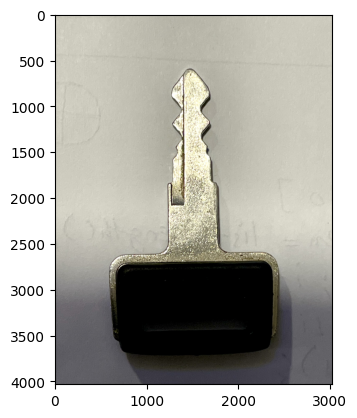

In [136]:
plt_img(key_images[0].rgb_img)

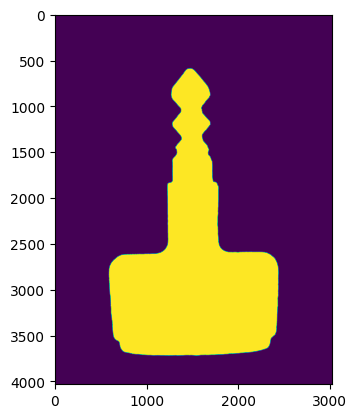

In [137]:
plt_img(key_images[0].mask_img)

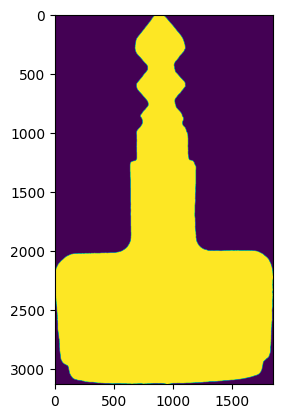

In [138]:
plt_img(key_images[0].cropped_mask)

# Step2: Resize keys to 512x512